In [3]:
import numpy as np
import matplotlib.pylab as plt

### Define the constant

In [4]:
## define alpha
alpha=1.11*(10**(-4))#*100

### Define the variables

In [5]:
## define x
nx=200
x=np.linspace(0,1,nx)
dx=x[1]-x[0]

## define t
nt=10000
t=np.linspace(0,10,nt)
dt=t[1]-t[0]

## define T with zeros
T=np.zeros((nx,nt),dtype=np.float64)

### Set the Initial and Boundary Conditions

In [6]:
## Initial condition
T[:,0]=300.

### Define the matrix A and fill in the three diagonal part

In [7]:
%%time

### define A
A=np.zeros((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)
for i in range(1,nx-1):
	A[i,i]=-(2.*C+1.0)
	A[i,i+1]=C
	A[i,i-1]=C

CPU times: user 181 μs, sys: 35 μs, total: 216 μs
Wall time: 166 μs


### Finalize A and b, and solve for the temperature

In [8]:
%%time

for k in range(0,nt-1):
    #define off-diagonal elements of A
    A[0,0]=1.
    A[nx-1,nx-1]=1.
    
    #define b
    b=np.zeros((nx,),dtype=np.float64)
    
    b[0]=400
    b[nx-1]=300
    for i in range(1,nx-1):
        b[i]=-T[i,k]
    
    #calculate T
    T[:,k+1]=np.linalg.solve(A,b)

CPU times: user 2.93 s, sys: 42.9 ms, total: 2.97 s
Wall time: 2.94 s


### Plot the Temperature change at 10 different timestamps

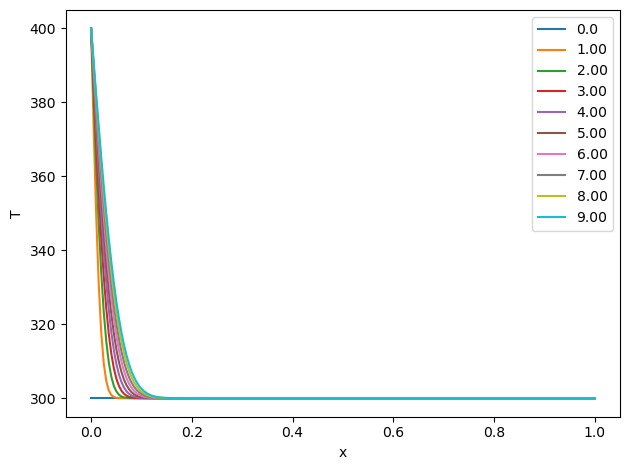

In [9]:
fig, ax=plt.subplots(1,1)
for k in range(0,nt,int(nt/10)):
	ax.plot(x,T[:,k], label=str(k*dt)[:4]);
ax.set_xlabel('x');
ax.set_ylabel('T')
fig.tight_layout()
plt.legend()
plt.show()

## Vectorizing A formation

In [10]:
%%time

"""
# Original implementation

A=sp.lil_matrix((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

for i in range(1,nx-1):
	A[i,i]=-(2.*C+1.0)
	A[i,i+1]=C
	A[i,i-1]=C
"""
C=alpha*dt/(dx**2)

A_vec = -(2.*C+1.0)*np.eye(nx)
udiag = C*np.eye(nx,k=1)
ldiag = C*np.eye(nx,k=-1)
A_vec += udiag+ldiag

CPU times: user 812 μs, sys: 0 ns, total: 812 μs
Wall time: 552 μs


**It doesn't have a major impact. It can even be slower!**\
**Sometimes, we need to look for something better**

## Sparse Matrix

In [11]:
import scipy.sparse as sp

### Sparse definition of zeros matrix

In [12]:
## define Tsp with zeros
"""
    # original implementation
    Tsp=np.zeros((nx,nt),dtype=np.float64)
    NOT CHANGING IT NOW
"""
Tsp=np.zeros((nx,nt),dtype=np.float64)

## Initial condition
Tsp[:,0]=300.

In [13]:
%%time

## define Asp
"""
# original implementation

A=np.zeros((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

for i in range(1,nx-1):
	A[i,i]=-(2.*C+1.0)
	A[i,i+1]=C
	A[i,i-1]=C
"""
Asp=sp.lil_matrix((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

for i in range(1,nx-1):
	Asp[i,i]=-(2.*C+1.0)
	Asp[i,i+1]=C
	Asp[i,i-1]=C

CPU times: user 649 μs, sys: 52 μs, total: 701 μs
Wall time: 701 μs


In [14]:
Asp

<List of Lists sparse matrix of dtype 'float64'
	with 594 stored elements and shape (200, 200)>

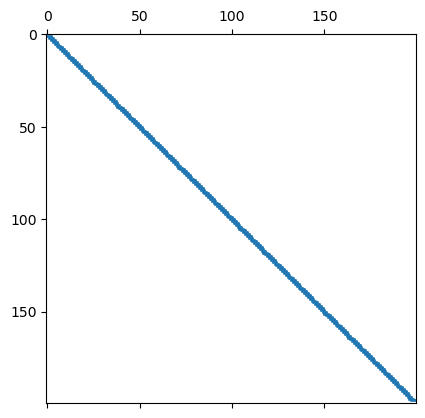

In [15]:
plt.spy(Asp,ms=1)

### Finalize Asp and b, and solve for the temperature
We are not changing the implementation to 

In [16]:
%%time

for k in range(0,nt-1):
    #define off-diagonal elements of A
    Asp[0,0]=1.
    Asp[nx-1,nx-1]=1.
    
    #define b
    """
    # original implementation
    
    b=np.zeros((nx,),dtype=np.float64)
    NOT CHANGING IT NOW
    """
    bsp=np.zeros((nx,),dtype=np.float64)
    
    bsp[0]=400
    bsp[nx-1]=300
    for i in range(1,nx-1):
        bsp[i]=-Tsp[i,k]
    
    #calculate T
    """
    # original implementation
    
    T[:,k+1]=np.linalg.solve(A,b)
    """
    Tsp[:,k+1]=sp.linalg.spsolve(Asp.tocsr(),bsp);

CPU times: user 1.64 s, sys: 7.73 ms, total: 1.65 s
Wall time: 1.66 s


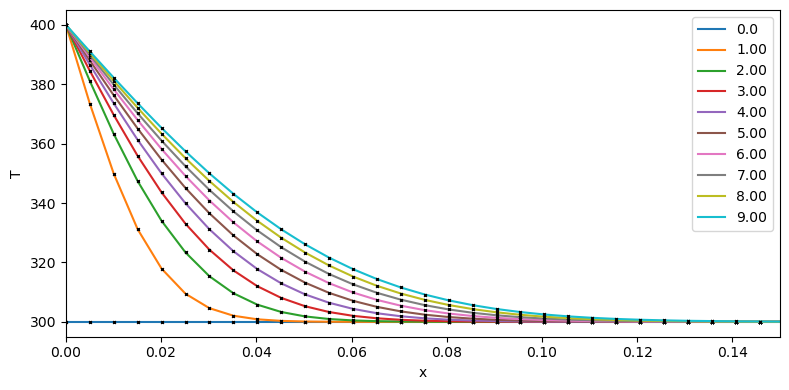

In [17]:
fig, ax=plt.subplots(1,1,figsize=(8,4))
for k in range(0,nt,int(nt/10)):
    ax.plot(x,T[:,k], label=str(k*dt)[:4]);
    ax.plot(x,Tsp[:,k],'x',ms=2,color='black');
ax.set_xlabel('x');
ax.set_ylabel('T')
ax.set_xlim([0,0.15])
fig.tight_layout()
plt.legend()
plt.show()

### Let's make it fully sparse! Change Tsp and bsp formulation.

In [18]:
## define Tsp with zeros
"""
    # original implementation
    Tsp=np.zeros((nx,nt),dtype=np.float64)
"""
Tsp=sp.lil_matrix((nx,nt),dtype=np.float64)

## Initial condition
Tsp[:,0]=300.

In [19]:
%%time

## define Asp
"""
# original implementation

A=np.zeros((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

for i in range(1,nx-1):
	A[i,i]=-(2.*C+1.0)
	A[i,i+1]=C
	A[i,i-1]=C
"""
Asp=sp.lil_matrix((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

for i in range(1,nx-1):
	Asp[i,i]=-(2.*C+1.0)
	Asp[i,i+1]=C
	Asp[i,i-1]=C

CPU times: user 869 μs, sys: 0 ns, total: 869 μs
Wall time: 879 μs


In [20]:
%%time

for k in range(0,nt-1):
    #define off-diagonal elements of A
    Asp[0,0]=1.
    Asp[nx-1,nx-1]=1.
    
    #define b
    """
    # original implementation
    
    b=np.zeros((nx,),dtype=np.float64)
    """
    bsp=sp.lil_matrix((nx,1),dtype=np.float64)
    
    bsp[0]=400
    bsp[nx-1]=300
    for i in range(1,nx-1):
        bsp[i]=-Tsp[i,k]
    
    #calculate T
    """
    # original implementation
    
    T[:,k+1]=np.linalg.solve(A,b)
    """
    Tsp[:,k+1]=sp.linalg.spsolve(Asp.tocsr(),bsp);

CPU times: user 36.1 s, sys: 140 ms, total: 36.2 s
Wall time: 36.3 s


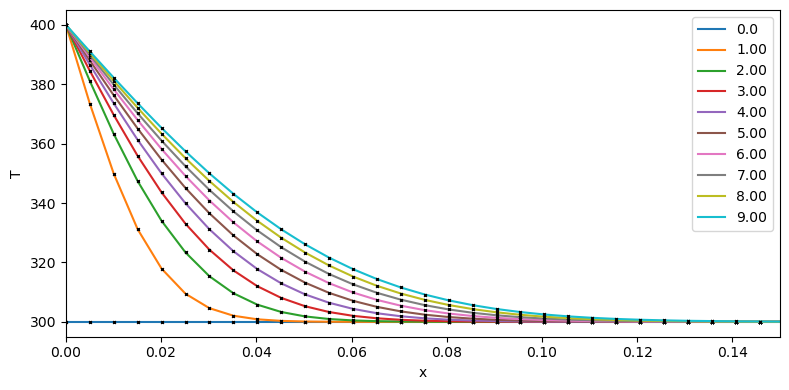

In [21]:
fig, ax=plt.subplots(1,1,figsize=(8,4))
for k in range(0,nt,int(nt/10)):
    ax.plot(x,T[:,k], label=str(k*dt)[:4]);
    ax.plot(x,Tsp[:,k].todense(),'x',ms=2,color='black');
ax.set_xlabel('x');
ax.set_ylabel('T')
ax.set_xlim([0,0.15])
fig.tight_layout()
plt.legend()
plt.show()

**Why is it slower???**

- Constantly modifying the elements of a sparse matrix is very costly. Here, `Tsp` matrix and `bsp` vector change in every time-step
- Numpy routines are automatically multi-threaded but scipy is not!